In [35]:
import warnings
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

import skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

In [2]:
# Read data
# ==============================================================================
df = pd.read_csv('Data/spain/spain_clean.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index(keys = 'datetime', inplace=True)
df = df.asfreq('60min')
df.head()

,wave_height,period
datetime,,
2023-06-15 00:00:00,0.58,4.85
2023-06-15 01:00:00,0.57,4.85
2023-06-15 02:00:00,0.56,4.85
2023-06-15 03:00:00,0.55,4.85
2023-06-15 04:00:00,0.55,4.86


In [3]:
# Train-test split
# ==============================================================================
one_month = (-1)*30*24 # One month
two_months = (-1)*60*24 # Two months

end_train = one_month + two_months
end_val = one_month

df_train = df.iloc[:end_train].copy()
df_val = df.iloc[end_train:end_val].copy()
df_test = df.iloc[end_val:].copy()

print(f"Train dates      : {df_train.index.min()} --- {df_train.index.max()}  (n={len(df_train)})")
print(f"Validation dates : {df_val.index.min()} --- {df_val.index.max()}  (n={len(df_val)})")
print(f"Test dates       : {df_test.index.min()} --- {df_test.index.max()}  (n={len(df_test)})")

Train dates      : 2023-06-15 00:00:00 --- 2024-03-24 23:00:00  (n=6816)
Validation dates : 2024-03-25 00:00:00 --- 2024-05-23 23:00:00  (n=1440)
Test dates       : 2024-05-24 00:00:00 --- 2024-06-22 23:00:00  (n=720)


## Exploration

In [15]:
df_fd = df.diff().dropna()

In [16]:
# Stationarity tests
# ==============================================================================
warnings.filterwarnings("ignore")

print('Test stationarity for original series')
print('-------------------------------------')
adfuller_result = adfuller(df['wave_height'])
kpss_result = kpss(df['wave_height'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest stationarity for differenced series, d=1')
print('-------------------------------------')
adfuller_result = adfuller(df_fd['wave_height'])
kpss_result = kpss(df_fd['wave_height'])
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

Test stationarity for original series
-------------------------------------
ADF Statistic: -7.433425356299192, p-value: 6.273296233203401e-11
KPSS Statistic: 1.0855701665093762, p-value: 0.01

Test stationarity for differenced series, d=1
-------------------------------------
ADF Statistic: -18.361680991210363, p-value: 2.2266302021992167e-30
KPSS Statistic: 0.006460140402142037, p-value: 0.1


Weirdly, the KPSS and ADF tests give contradictory results on the original series. While we reject the null of no stationarity in the ADF, we also reject the null hypothesis of stationarity in the KPSS test. When we take first differences, the result of the ADF holds (with even more significance), while the result of the KPSS flips: we can't reject the null of stationarity in the first differences. 

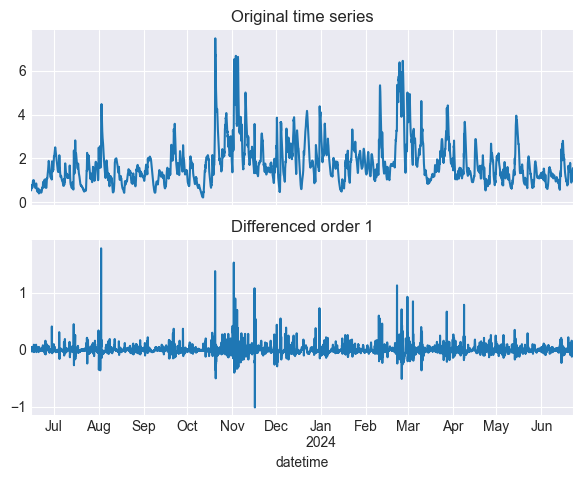

In [36]:
# Plot series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 5), sharex=True)

df['wave_height'].plot(ax=axs[0], title='Original time series')
df_fd['wave_height'].plot(ax=axs[1], title='Differenced order 1')

plt.show()


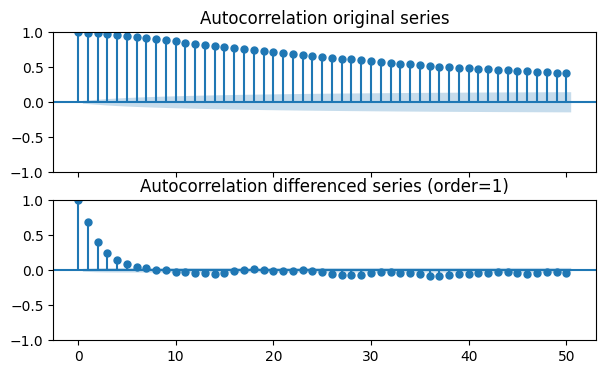

In [20]:
# Autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 4), sharex=True)
plot_acf(df['wave_height'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelation original series')
plot_acf(df_fd['wave_height'], ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelation differenced series (order=1)');   

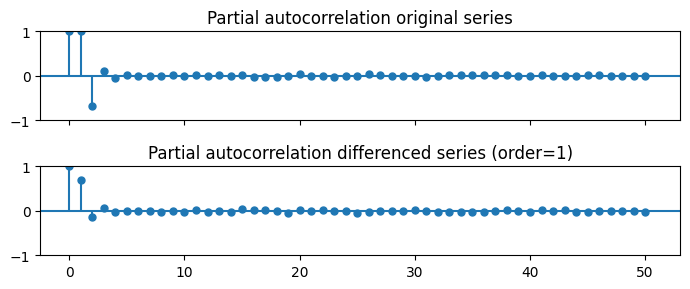

In [21]:
# Partial autocorrelation plot for original and differenced series
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(7, 3), sharex=True)
plot_pacf(df['wave_height'], ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Partial autocorrelation original series')
plot_pacf(df_fd['wave_height'], ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Partial autocorrelation differenced series (order=1)');
plt.tight_layout();

## Modelling

In [29]:
# Define forecaster
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1),
                                # seasonal_order=(1, 1, 1, 12),
                                maxiter=200
                            )
             )

In [31]:
# Backtest forecaster
# ==============================================================================
metric, predictions = backtesting_sarimax(
                          forecaster            = forecaster,
                          y                     = df['wave_height'],
                          initial_train_size    = len(df.iloc[:end_val]),
                          fixed_train_size      = False,
                          steps                 = 24,
                          metric                = 'mean_absolute_error',
                          refit                 = True,
                          n_jobs                = "auto",
                          suppress_warnings_fit = True,
                          verbose               = True,
                          show_progress         = True
                      )
print(f"Metric (mean_absolute_error): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 8256
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2023-06-15 00:00:00 -- 2024-05-23 23:00:00  (n=8256)
    Validation: 2024-05-24 00:00:00 -- 2024-05-24 23:00:00  (n=24)
Fold: 1
    Training:   2023-06-15 00:00:00 -- 2024-05-24 23:00:00  (n=8280)
    Validation: 2024-05-25 00:00:00 -- 2024-05-25 23:00:00  (n=24)
Fold: 2
    Training:   2023-06-15 00:00:00 -- 2024-05-25 23:00:00  (n=8304)
    Validation: 2024-05-26 00:00:00 -- 2024-05-26 23:00:00  (n=24)
Fold: 3
    Training:   2023-06-15 00:00:00 -- 2024-05-26 23:00:00  (n=8328)
    Validation: 2024-05-27 00:00:00 -- 2024-05-27 23:00:00  (n=24)
Fold: 4
    Training:   2023-06-15 00:00:00 -- 2024-05-27 23:00:00  (n=8352)
    Validation: 2024-05-28 00:00

100%|██████████| 30/30 [00:19<00:00,  1.57it/s]

Metric (mean_absolute_error): 0.2184269477754984


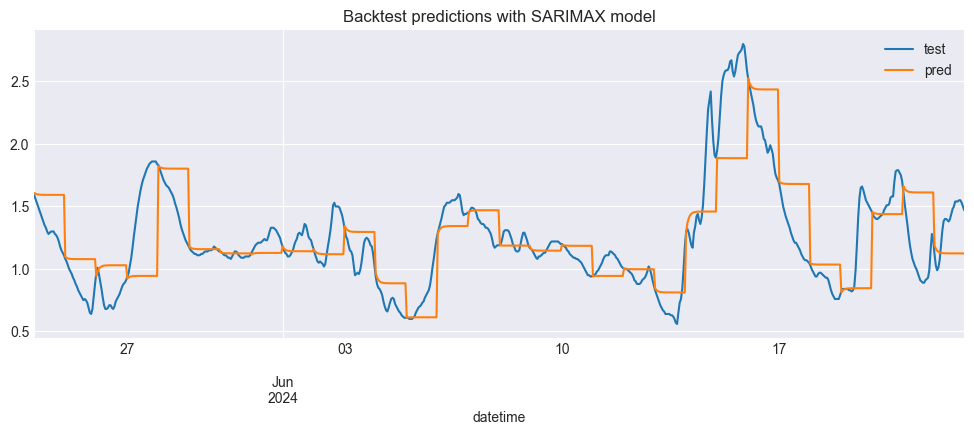

In [38]:
# Plot backtest predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
df['wave_height'].iloc[end_val:].plot(ax=ax, label='test')
predictions.plot(ax=ax)
ax.set_title('Backtest predictions with SARIMAX model')
ax.legend();

### Hyperparameter tuning


In [45]:
# Grid search based on backtesting
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=200
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    # 'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = df['wave_height'].iloc[:end_val],
                   param_grid            = param_grid,
                   steps                 = 24,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(df_train),
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )

results_grid.head(5)

Number of models compared: 15.


params grid:   0%|          | 0/15 [00:00<?, ?it/s]/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/model_selection_sarimax/model_selection_sarimax.py:194: LongTrainingWarning: The forecaster will be fit 60 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
params grid:   7%|▋         | 1/15 [00:05<01:14,  5.29s/it]/Users/alvarocorralescano/opt/anaconda3/envs/waves/lib/python3.11/site-packages/skforecast/model_selection_sarimax/model_selection_sarimax.py:194: LongTrainingWarning: The forecaster will be fit 60 times. This can take substantial amounts of time. If not feasible, try with `refit = False`.
 
 You can suppress this warning using: warnings.simplefilter('ignore', category=LongTrainingWarning)
  warnings.warn(
params grid:  13%|█▎        | 2/15 [00:10<01:08,  5.24s/it]/Users/alva

,params,mean_absolute_error,order,trend
6,"{'order': (1, 1, 0), 'trend': None}",0.276217,"(1, 1, 0)",None
7,"{'order': (1, 1, 0), 'trend': 'n'}",0.276217,"(1, 1, 0)",n
8,"{'order': (1, 1, 0), 'trend': 'c'}",0.276566,"(1, 1, 0)",c
12,"{'order': (2, 1, 1), 'trend': None}",0.281187,"(2, 1, 1)",None
13,"{'order': (2, 1, 1), 'trend': 'n'}",0.281187,"(2, 1, 1)",n


In [46]:
results_grid.head(10)

,params,mean_absolute_error,order,trend
6,"{'order': (1, 1, 0), 'trend': None}",0.276217,"(1, 1, 0)",None
7,"{'order': (1, 1, 0), 'trend': 'n'}",0.276217,"(1, 1, 0)",n
8,"{'order': (1, 1, 0), 'trend': 'c'}",0.276566,"(1, 1, 0)",c
12,"{'order': (2, 1, 1), 'trend': None}",0.281187,"(2, 1, 1)",None
13,"{'order': (2, 1, 1), 'trend': 'n'}",0.281187,"(2, 1, 1)",n
14,"{'order': (2, 1, 1), 'trend': 'c'}",0.281517,"(2, 1, 1)",c
9,"{'order': (1, 1, 1), 'trend': None}",0.282598,"(1, 1, 1)",None
10,"{'order': (1, 1, 1), 'trend': 'n'}",0.282598,"(1, 1, 1)",n
11,"{'order': (1, 1, 1), 'trend': 'c'}",0.282989,"(1, 1, 1)",c
3,"{'order': (0, 1, 1), 'trend': None}",0.299935,"(0, 1, 1)",None


In [60]:
# Backtest predictions with the best model according to grid search
# ==============================================================================
forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(1, 1, 0), maxiter=200),
             )

metric_m1, predictions_m1 = backtesting_sarimax(
                                forecaster            = forecaster,
                                y                     = df['wave_height'],
                                initial_train_size    = len(df['wave_height'].iloc[:end_val]),
                                steps                 = 12,
                                metric                = 'mean_absolute_error',
                                refit                 = False,
                                n_jobs                = "auto",
                                suppress_warnings_fit = True,
                                verbose               = False,
                                show_progress         = True
                            )

100%|██████████| 60/60 [00:02<00:00, 20.60it/s]


Metric (mean_absolute_error) for grid search model: 0.12433816969975374


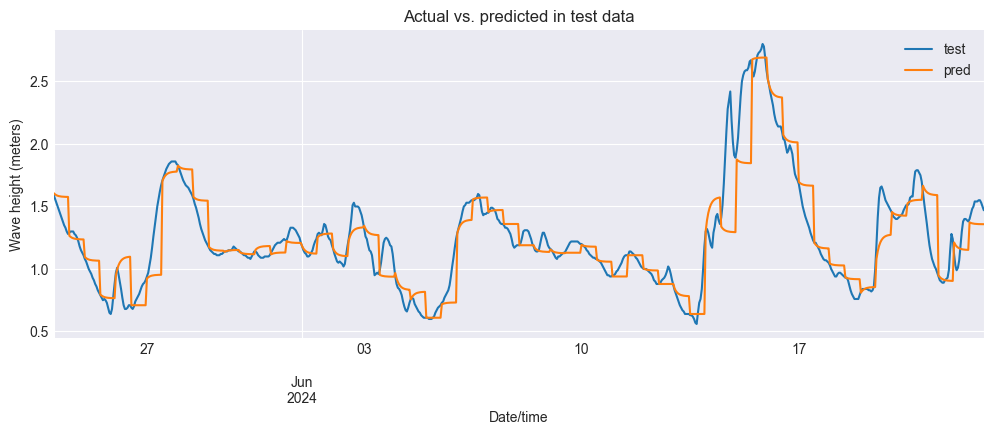

In [61]:
# Compare predictions
# ==============================================================================
print(f"Metric (mean_absolute_error) for grid search model: {metric_m1}")

fig, ax = plt.subplots(figsize=(12, 4))
df['wave_height'].iloc[end_val:].plot(ax=ax, label='test')
predictions_m1.plot(ax=ax)
ax.set_title('Actual vs. predicted in test data')
ax.set_ylabel('Wave height (meters)')
ax.set_xlabel('Date/time')
ax.legend();
